The Codes for the paper "Improving Model-Agnostic Distillation for Large Language Models" is included here. The code is based on HugginFace API of transformer in pytorch. The relevant packages are mentioned below. Uncomment the installtion if you are running it for the first time. The notebook already assumes that Pytorch and relevant packages are pre-installed

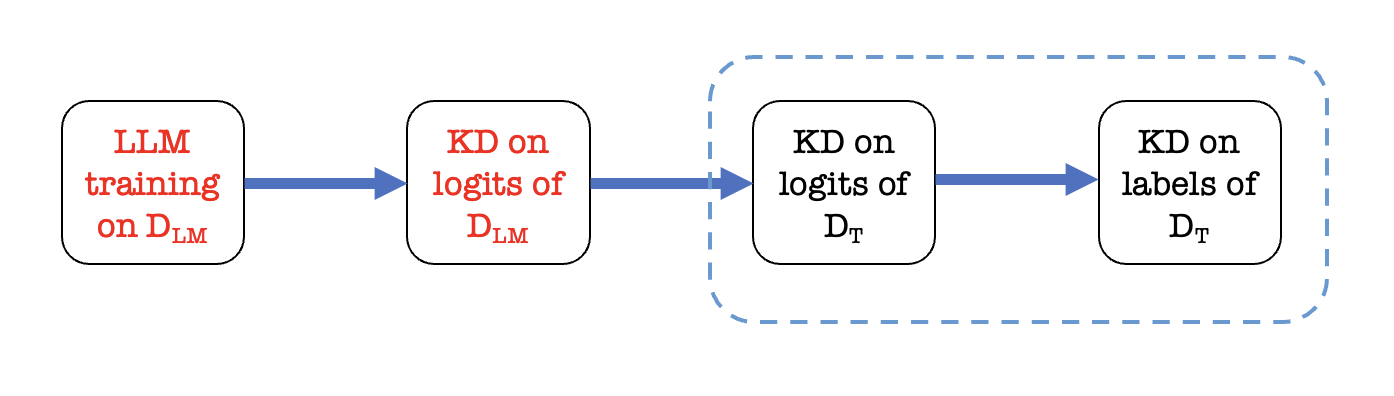

In [ ]:
!pip install  -U transformers datasets evaluate thop pthflops scipy sklearn scikit-learn tensorboardX
!pip install --upgrade accelerate
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mention the Teacher transformer id, student id, and dataset id as per the convention of Huggingface. Choose any of the 24 student ids for BERT from https://huggingface.co/google/bert_uncased_L-2_H-128_A-2. The default dataset is set to SST2 and the default metric is set to accuracy. Also, change the tokenizer according to the fields present in the dataset.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset_id="glue"
dataset_config="sst2"
dataset = load_dataset(dataset_id,dataset_config)
student_key = "L-2_H-128_A-2"
student_id = "google/bert_uncased_" + student_key
teacher_id = "bert-base-uncased"
repo_name = student_key + "_" + dataset_config
metric_key = "accuracy"


def process(examples):
  #tokenized_inputs = tokenizer(examples["premise"], examples["hypothesis"],truncation=True, max_length=512)
  tokenized_inputs = tokenizer(examples["sentence"],padding="max_length", truncation=True)
  return tokenized_inputs


tokenizer = AutoTokenizer.from_pretrained(teacher_id);


tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label","labels")

  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Sign into huggingface and generate the token

In [ ]:
from huggingface_hub import notebook_login
 
notebook_login()

Instatiate the student and the teacher using the transformer API

In [ ]:
from huggingface_hub import HfFolder
from transformers import AutoConfig,DataCollatorWithPadding,AutoModelForSequenceClassification
from transformers import DistilBertConfig, DistilBertModel, DistilBertForSequenceClassification

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# define training args

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    #output_hidden_states = True
)


student_model = AutoModelForSequenceClassification.from_pretrained(
    student_id ,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

#student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, n_layers = 2, output_hidden_states = True) #For Distillbert
torch.cuda.empty_cache()




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Define the distillation loss. Two types of loss is defined here, the MSE Loss between logits and the KL Divergence between the Softmax. Also, the Cosine Loss for distillbert is defined here too. Uncomment the relevant loss for distillation

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamWeightDecay

Loss_cos = nn.CosineEmbeddingLoss(reduction="mean")

class KDMSELoss(nn.Module):
    """
    Loss with knowledge distillation.
    """
    def __init__(self, alpha=0.5, scale='logp'):
        super().__init__()
        assert scale in ['logp', 'p']
        self.alpha = alpha
        self.scale = scale

    def forward(self, student_logit, teacher_logit, target, loss_original):
        if self.scale == 'logp':
            loss_kd = F.mse_loss(student_logit, teacher_logit)
        else:
            p = F.softmax(teacher_logit, dim=-1)
            loss_kd = F.mse_loss(student_logit, p)
        return (1 - self.alpha) * loss_original + self.alpha * loss_kd


class KDMSEVarRedOrthoLoss(KDMSELoss):
    """
    Loss with knowledge distillation.
    """
    def __init__(self, alpha=0.5, smoothing=0.0):
        super().__init__(alpha)
        self.smoothing = smoothing

    def forward(self, student_logit, teacher_logit, target, loss_original):
        p = F.softmax(teacher_logit, dim=-1)
        if self.smoothing > 0.0:
            uniform = torch.ones_like(p) / student_logit.shape[-1]
            p = (1.0 - self.smoothing) * p + self.smoothing * uniform
        y = F.one_hot(target, student_logit.shape[-1]).float()
        yp_1 = y / p - 1.0
        loss_kd = ((student_logit - teacher_logit - yp_1 )**2 * p).mean() 
        return (1 - self.alpha) * loss_original + self.alpha * loss_kd

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=1.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher = teacher_model
    self._move_model_to_device(self.teacher,self.model.device)
    self.teacher.eval()
    self.eps = 1e-6
    
  
  def compute_loss(self, model, inputs, return_outputs=False):
    outputs_student = model(**inputs)
    student_loss= outputs_student.loss
    with torch.no_grad():
      outputs_teacher = self.teacher(**inputs)
      assert outputs_student.logits.size() == outputs_teacher.logits.size()

    # Uncomment for Cosine-loss for Distillbert
#     [bs,slen,dim] = outputs_student.hidden_states[0].size()
#     ones = torch.ones(bs*slen).cuda()
#     loss += Loss_cos(outputs_student.hidden_states[0].view(-1, dim), outputs_teacher.hidden_states[0].view(-1, dim),ones)

     #Uncomment for KL Divergence Loss
#     Loss = torch.nn.KLDivLoss(reduction = "batchmean")
#     loss_kd = (Loss(F.log_softmax(outputs_student.logits , dim=-1), F.softmax(outputs_teacher.logits , dim=-1)) )
#     target = inputs.pop('labels')
#     y = F.one_hot(target, outputs_student.logits .shape[-1]).float()
#     loss_kd -= ((y-F.softmax(outputs_teacher.logits , dim=-1))*F.log_softmax(outputs_student.logits , dim=-1)).sum()/y.shape[0]
#     #print(student_loss.item(), loss_kd.item())
#     loss = (1 - self.args.alpha) * student_loss + self.args.alpha * loss_kd

    #Uncomment MSE Loss
    Loss = KDMSEVarRedOrthoLoss(self.args.alpha)
    loss = Loss(outputs_student.logits, outputs_teacher.logits,inputs.get("labels"),student_loss)
    


    return (loss, outputs_student) if return_outputs else loss


Declare the training arguments according to Hugginface trainer API. Set the hyperparameters e.g. learning rate, alpha, epoch, batch sizes etc. Define the evaluation metrics, and then evaluate the student using the metrics. 

In [ ]:
from datasets import load_metric
import numpy as np
from evaluate import load
training_args = DistillationTrainingArguments(
    output_dir=repo_name,
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    fp16=True,
    learning_rate=2e-5,
    seed=99,
    # logging & evaluation strategies
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_key,
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    # distilation parameters
    alpha=0.5,
    temperature=1.0
    )

glue_metric = load('glue',dataset_config)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return glue_metric.compute(predictions=predictions, references=labels)

    
    # # F1 = load_metric( "f1").compute(predictions=predictions, references=labels, average = "micro")
    # acc = load_metric("accuracy").compute(predictions=predictions, references=labels)
    # mc = load_metric("matthews_correlation").compute(predictions=predictions, references=labels)


    # return {
    #     "MC": mc['matthews_correlation'] 
    # }

#'tiny-bert-qqp-distilled-6/checkpoint-85290':87.4 tiny-bert-qnli-distilled-6/checkpoint-36014: 89.4, tiny-bert-mnli-distilled-6/checkpoint-184080: 81.8(m) tiny-bert-sst2-distilled-6/checkpoint-6318:90.94 tiny-bert-rte-distilled-6/checkpoint-390:67.2 
# tiny-bert-rte-distilled-6/checkpoint-585: 67.5, 'tiny-bert-sst2-distilled-6/checkpoint-9477': 91.17, tiny-bert-cola-distilled-6/checkpoint-1340: 55.3
trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    )

trainer.evaluate()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│ in __init__:48                                                                                   │
│ in __init__:111                                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1337 in __post_init__      │
│                                                                                                  │
│   1334 │   │   │   and (get_xla_device_type(self.device) != "GPU")                               │
│   1335 │   │   │   and (self.fp16 or self.fp16_full_eval)                                        │
│   1336 │   │   ):                                                                                │
│ ❱ 1337 │   │   │   raise ValueError(                                                             │
│   1338 │   │   │   │   "FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half  │
│   1339 │   │   │   │   " (`--fp16_full_eval`) can only be used on CUDA devices."                 │
│   1340 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation 
(`--fp16_full_eval`) can only be used on CUDA devices.

Finally train the model. The Pytorch CUDA ALLOC limits the memory split to prevent CUDA memory overflow. Evaluate once the training is over

In [ ]:
!set PYTORCH_CUDA_ALLOC_CONF = max_split_size_mb:512
torch.cuda.empty_cache()

trainer.train()

trainer.evaluate()
